## Processing Ocean Color Imagery - Process Micasense Images

Pull in all images and process with micasense tools
    normalize and align and whatnot
    put these into functions and clean up
    also visualize along the way and look at distributions to think about whether or not they're legitimate
    write out
    
Pull in all images as modified and metadata with specific functions
    Visualize for issues and shadows and bright spots and locations
    correct for sky radiance
    visualize the distributions of both sky (clouds) and sea
    look at the variability of spectra both for specific pixels and across nearby images
    filter for orientation and location and issues

take the water leaving spectra and convert to chla as well as other future products and just intro general analysis of spectra
    produce a csv or .shp or images of ocean color products 
    

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ipywidgets import FloatProgress, Layout
from IPython.display import display
from micasense import imageset as imageset
from micasense import capture as capture
import multiprocessing
import glob, shutil, os

import cv2
import numpy as np
import matplotlib.pyplot as plt


import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

import exiftool
import datetime

import subprocess
import math

from utils import *
from georeg import *

In [3]:
project_name = '210827_A2_frontcross2'

Inspect the Exposure, gain, DLS

In [4]:
surface_dir = os.path.join('data', project_name, 'sea')

In [5]:
imgset = imageset.ImageSet.from_directory(surface_dir)

In [6]:
dls_ed = []
exposures = []
gains = []
for cap in imgset.captures:
    if len(cap.dls_irradiance()) == 6:
        dls_ed.append(np.array(cap.dls_irradiance()))
        exp = []
        gain_cap = []
        for img in cap.images: 
            exp.append(img.exposure_time)
            gain_cap.append(img.gain)
        exposures.append(exp)
        gains.append(gain_cap)
        
exposures = np.array(exposures)
gains = np.array(gains)
dls_ed = np.array(dls_ed)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/

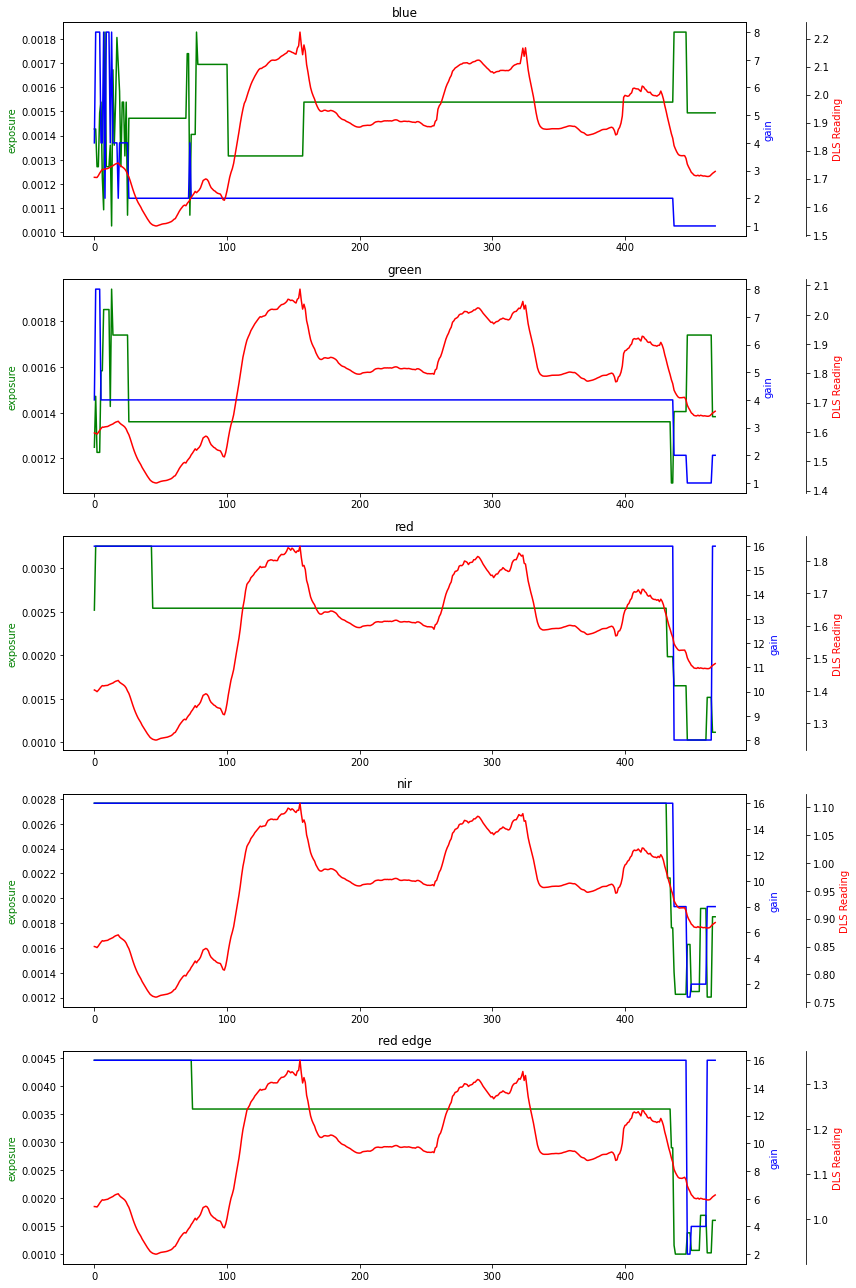

In [9]:
band_names = ['blue', 'green', 'red', 'nir', 'red edge']

fig, ax = plt.subplots(5,1, figsize=(12,18))

for i in range(5):
    ax[i].plot(exposures[:,i], color='green')
#     ax[i].set_ylim(0,.002)
    ax2 = ax[i].twinx()
    ax2.plot(gains[:,i], color='blue')
#     ax2.set_ylim(0,8.2)
    ax3 = ax[i].twinx()
    ax3.plot(dls_ed[:,i], color='red')
#     ax3.set_ylim(.22,.5)
    ax3.spines['right'].set_position(('outward', 60))
    
    ax[i].set_ylabel('exposure')
    ax2.set_ylabel('gain')
    ax3.set_ylabel('DLS Reading')
    
    ax[i].yaxis.label.set_color('green')
    ax2.yaxis.label.set_color('blue')
    ax3.yaxis.label.set_color('red')
    
    ax[i].set_title(band_names[i])
    fig.tight_layout()
#     fig.savefig('gain_exposure_dls.png',dpi=300)
    fig.show()
#     

### Run the process

In [11]:
project_name

'210827_A2_frontcross2'

In [12]:
! ls data/210827_A2_frontcross2/

0000SET  panel	RedEdge  sea  SYNLog-19-08-13_27-08-2021.csv


### This is the typical full workflow

In [13]:
glob.glob(os.path.join('data', project_name, 'panel', 'IMG_0005*.tif'))

['data/210827_A2_frontcross2/panel/IMG_0005_3.tif',
 'data/210827_A2_frontcross2/panel/IMG_0005_2.tif',
 'data/210827_A2_frontcross2/panel/IMG_0005_5.tif',
 'data/210827_A2_frontcross2/panel/IMG_0005_4.tif',
 'data/210827_A2_frontcross2/panel/IMG_0005_6.tif',
 'data/210827_A2_frontcross2/panel/IMG_0005_1.tif']

#### First process the Altum images

From https://support.micasense.com/hc/en-us/articles/360025336894-Using-Panels-and-or-DLS-in-Post-Processing

In the case of a clear, sunny day, we recommend using only the calibration panels. Light sensor data will not be as effective and so should generally not be used in this case.

Light sensor data is most effective in overcast, completely cloudy conditions. In this case, we would recommend using both light sensor and panel data for calibration.

In [14]:
# to use the DLS and not the panel set this to None
# panelNames = None
panelNames = glob.glob(os.path.join('data', project_name, 'panel', 'IMG_0005*.tif'))

warp_img_dir = os.path.join('data', project_name, 'sea', 'align_img')
surface_out = process_micasense_subset(surface_dir, panelNames, warp_img_dir, overwrite=False)

Panel irradiance calculated.
used warp dir data/210827_A2_frontcross2/sea/align_img
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 2
Finished aligning band 1
Finished aligning band 3
Finished aligning band 4
Saving time: 0:25:43.199949
Alignment+Saving rate: 0.30 images per second
Finished saving images.
exiftool -csv="data/210827_A2_frontcross2/sea/stacks/log.csv" -overwrite_original data/210827_A2_frontcross2/sea/stacks
Finished saving image metadata.


In [15]:
! exiftool -csv="data/210827_A2_frontcross2/sea/stacks/log.csv" -overwrite_original data/210827_A2_frontcross2/sea/stacks

    1 directories scanned
  468 image files updated


#### Now process the RedEdge Images

Need to ensure these are the correct images via time. They do seem correct.

Also note that the first couple sea images were bad because of spray and glint and shadow.

In [16]:
panelNames = glob.glob(os.path.join('data', project_name, 'RedEdge', 'panel', 'IMG_0002*.tif'))
panelNames

['data/210827_A2_frontcross2/RedEdge/panel/IMG_0002_5.tif',
 'data/210827_A2_frontcross2/RedEdge/panel/IMG_0002_2.tif',
 'data/210827_A2_frontcross2/RedEdge/panel/IMG_0002_4.tif',
 'data/210827_A2_frontcross2/RedEdge/panel/IMG_0002_3.tif',
 'data/210827_A2_frontcross2/RedEdge/panel/IMG_0002_1.tif']

In [17]:
# to use the DLS and not the panel set this to None
#panelNames = None
panelNames = glob.glob(os.path.join('data', project_name, 'RedEdge', 'panel', 'IMG_0002*.tif'))

blocked_dir = os.path.join('data', project_name, 'RedEdge', 'tube')
sky_dir = os.path.join('data', project_name, 'RedEdge', 'sky')
surface_dir = os.path.join('data', project_name, 'RedEdge', 'sea')

warp_img_dir = os.path.join('data', project_name, 'RedEdge', 'tube')
sunlight_blocked_out = process_micasense_subset(blocked_dir, panelNames, warp_img_dir, overwrite=False)

warp_img_dir = os.path.join('data', project_name, 'RedEdge', 'sky')
sky_out = process_micasense_subset(sky_dir, panelNames, warp_img_dir, overwrite=False)

warp_img_dir = os.path.join('data', project_name, 'RedEdge', 'sea')
surface_out = process_micasense_subset(surface_dir, panelNames, warp_img_dir, overwrite=False)

Panel irradiance calculated.
used warp dir data/210827_A2_frontcross2/RedEdge/tube
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 1
Finished aligning band 3
Finished aligning band 4
Finished aligning band 2
Saving time: 0:00:22.161470
Alignment+Saving rate: 0.72 images per second
Finished saving images.
exiftool -csv="data/210827_A2_frontcross2/RedEdge/tube/stacks/log.csv" -overwrite_original data/210827_A2_frontcross2/RedEdge/tube/stacks
Finished saving image metadata.
Panel irradiance calculated.
used warp dir data/210827_A2_frontcross2/RedEdge/sky
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 0
Finished aligning band 4
Finished aligning band 2
Finished aligning band 3
Finished aligning band 1
Saving time: 0:00:04.497483
Alignment+Saving rate: 0.89 images per second
Finished saving images.
exiftool -csv="data/210827_A2_frontcross2/R

In [19]:
! exiftool -csv="data/210827_A2_frontcross2/RedEdge/tube/stacks/log.csv" -overwrite_original data/210827_A2_frontcross2/RedEdge/tube/stacks

    1 directories scanned
   16 image files updated


In [18]:
! exiftool -csv="data/210827_A2_frontcross2/RedEdge/sky/stacks/log.csv" -overwrite_original data/210827_A2_frontcross2/RedEdge/sky/stacks

    1 directories scanned
    4 image files updated


In [20]:
! exiftool -csv="data/210827_A2_frontcross2/RedEdge/sea/stacks/log.csv" -overwrite_original data/210827_A2_frontcross2/RedEdge/sea/stacks

    1 directories scanned
    4 image files updated
